In [2]:
import os
import numpy as np

import matplotlib.pyplot as pyplot

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Dense, Flatten, LeakyReLU
from keras import backend as K
import keras
from sklearn.metrics import roc_curve, auc,confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

import pandas as pd 

PATH = os.getcwd()+'/'
print(PATH)

Using TensorFlow backend.


/home/joey/Documents/MachineLearning/AIShakespeare/


### Import text

In [3]:
#Load file of Trump Tweets
with open('Shakespeares-Sonnets.txt',encoding='utf-8') as f:
    text = f.readlines()
text = pd.DataFrame(text)[0]
print(text[0]) #Print first instance

From fairest creatures we desire increase,



### Reformat

In [4]:
text = pd.DataFrame(text)[0]

print(text[0]) #Print first instance
TEXT = []
for i in range(len(text)):
    text[i] = keras.preprocessing.text.text_to_word_sequence(text[i],filters='!"#‘’“”$%&@()*+,-./:;<=>?[\\]…^_`{|}~\t\n')
    for j in range(len(text[i])):
        TEXT.append(text[i][j])
print(TEXT[0:100])

From fairest creatures we desire increase,

['from', 'fairest', 'creatures', 'we', 'desire', 'increase', 'that', 'thereby', "beauty's", 'rose', 'might', 'never', 'die', 'but', 'as', 'the', 'riper', 'should', 'by', 'time', 'decease', 'his', 'tender', 'heir', 'might', 'bear', 'his', 'memory', 'but', 'thou', 'contracted', 'to', 'thine', 'own', 'bright', 'eyes', "feed'st", 'thy', "light's", 'flame', 'with', 'self', 'substantial', 'fuel', 'making', 'a', 'famine', 'where', 'abundance', 'lies', 'thy', 'self', 'thy', 'foe', 'to', 'thy', 'sweet', 'self', 'too', 'cruel', 'thou', 'that', 'art', 'now', 'the', "world's", 'fresh', 'ornament', 'and', 'only', 'herald', 'to', 'the', 'gaudy', 'spring', 'within', 'thine', 'own', 'bud', 'buriest', 'thy', 'content', 'and', 'tender', 'churl', "mak'st", 'waste', 'in', 'niggarding', 'pity', 'the', 'world', 'or', 'else', 'this', 'glutton', 'be', 'to', 'eat', 'the']


Choose up to 5000 most common words and tokenize.

In [5]:
words = set(TEXT)
MAX_NB_WORDS = 5000
tokenizer = keras.preprocessing.text.Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(TEXT)
sequences = tokenizer.texts_to_sequences(text) #Convert tweets to numerical sequences

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3227 unique tokens.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


We can now see the most common words:

In [6]:
# summarize what was learned
#print(tokenizer.word_counts) #Counts for each word
#print(tokenizer.document_count) #Total num words in file
print(tokenizer.word_index) #Dictonary mapping in order of most common
#print(tokenizer.word_docs) #Dictonary mapping in order of appearance

#Create dictionary for token to work mappings. (Translation)
Char_to_Int = tokenizer.word_index
Int_to_Char = {Char_to_Int[k] : k for k in Char_to_Int}

{'and': 1, 'the': 2, 'to': 3, 'my': 4, 'of': 5, 'i': 6, 'in': 7, 'that': 8, 'thy': 9, 'thou': 10, 'with': 11, 'for': 12, 'is': 13, 'not': 14, 'love': 15, 'a': 16, 'me': 17, 'but': 18, 'thee': 19, 'so': 20, 'be': 21, 'as': 22, 'all': 23, 'you': 24, 'which': 25, 'his': 26, 'when': 27, 'this': 28, 'it': 29, 'by': 30, 'your': 31, 'doth': 32, 'do': 33, 'from': 34, 'on': 35, 'or': 36, 'no': 37, 'have': 38, 'then': 39, 'what': 40, 'are': 41, 'if': 42, 'more': 43, 'mine': 44, 'their': 45, 'shall': 46, 'sweet': 47, 'time': 48, 'will': 49, 'they': 50, 'eyes': 51, 'beauty': 52, 'nor': 53, 'art': 54, 'her': 55, 'yet': 56, 'heart': 57, 'o': 58, 'than': 59, 'self': 60, 'should': 61, 'thine': 62, 'now': 63, 'can': 64, 'one': 65, 'hath': 66, 'where': 67, 'fair': 68, 'make': 69, 'he': 70, 'still': 71, 'how': 72, 'true': 73, 'eye': 74, 'him': 75, 'like': 76, 'see': 77, 'am': 78, 'she': 79, 'those': 80, 'though': 81, 'being': 82, 'some': 83, 'such': 84, 'own': 85, 'every': 86, 'were': 87, 'dost': 88, 'wh

In [7]:
maximum = 0
maxword = ''
for i in range(len(sequences)):
    if len(sequences[i]) > maximum:
        maximum = len(sequences[i])
        index = i
        maxword = sequences[i]
print('MaxWordlength: %s' % (maximum))
print(maxword)

F = open('ShakespeareProcessed.txt', 'w')
for i in range(len(sequences)):
    if len(sequences[i]) > 3:
        LINE = [Int_to_Char[INT] for INT in sequences[i]]
        for j in range(len(sequences[i])):
            F.write(LINE[j]+' ')
        F.write(os.linesep)
F.close()

MaxWordlength: 11
[39, 93, 6, 566, 3, 463, 72, 6, 33, 15, 19]


In [22]:
# prepare the dataset of input to output pairs encoded as integers
train_length = 10 #Length of training sequence
step = 1 #More sequences
print('Training on sequences %s long' % (train_length))
dataX = []
dataY = []
for i in range(len(sequences)): #'Loop over data to split'
    if len(sequences[i]) > train_length:
        for j in range(0,len(sequences[i])-train_length,step):
            seq_in = sequences[i][j:train_length+j] #Some Trump seq
            seq_out = sequences[i][train_length+j] #The next charecter
            dataX.append(seq_in) #train_length of words in
            dataY.append(seq_out) #Prediction of one word out
        
print('%s training samples' % (len(dataX)))

Training on sequences 10 long
9 training samples


In [10]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (len(dataX), train_length))

# one hot encode the output variable
y = np_utils.to_categorical(dataY) #One-hot shot the output!


Perm = np.random.permutation(len(X))
X, y = X[Perm], y[Perm] #Random ordering. Hopefully make less bias to more recent events? Towards end of Epoch.

# Embedding

In [11]:
embeddings_index = {}
EMBEDDING_DIM = 100
with open(os.path.join('/home/joey/Documents/MachineLearning/glove.6B', 'glove.6B.%sd.txt' % (EMBEDDING_DIM))) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

In [12]:
# prepare embedding matrix
num_words = min(MAX_NB_WORDS, len(tokenizer.word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

WordCompare="love"
W1 = "change"
W2= "shame"

w1 = embeddings_index.get(W1)
w2 = embeddings_index.get(WordCompare)
A = np.dot(w2-w1,w2-w1)

w1 = embeddings_index.get(W2)
w2 = embeddings_index.get(WordCompare)
B = np.dot(w2-w1,w2-w1)

if A<B:
    print("\"%s\" is more similar to \"%s\" than \"%s\"" % (WordCompare, W1, W2))
else:
    print("\"%s\" is more similar to \"%s\" than \"%s\"" % (WordCompare, W2, W1))


"love" is more similar to "shame" than "change"


# NN

In [13]:
from keras.initializers import Constant

def Build_NN():
    inputs = keras.layers.Input(shape=(train_length,))
    x = keras.layers.Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=train_length,
                            trainable=False)(inputs)
    
    x = keras.layers.LSTM(EMBEDDING_DIM*4, return_sequences=True)(x)
    x = keras.layers.Dropout(0.2, name='Drop_1')(x)
    x = keras.layers.LSTM(EMBEDDING_DIM*4)(x)
    x = keras.layers.Dense(EMBEDDING_DIM)(x)
    predictions = keras.layers.Dense(y.shape[1],name='predictions',activation='softmax')(x)
    
    model = keras.models.Model(inputs = inputs, outputs = predictions)
    model.summary()
    

    sgd = keras.optimizers.adam()
    #####Compile model##########
    loss = 'categorical_crossentropy'
    model.compile(optimizer=sgd, loss=loss, metrics=['acc'])

    return model

def Train_NN(model,append,initial_epoch,end_epoch):
    # define the checkpoint
    callbacks_list = [
        keras.callbacks.ModelCheckpoint("weights-improvement-{epoch:02d}-{loss:.4f}.hdf5", monitor='loss', verbose=1, save_best_only=True, mode='min'),
        keras.callbacks.CSVLogger("TrainLog.csv", separator=',', append=append)
    ]
    # fit the model
    model.fit(X, y, epochs=end_epoch, batch_size=64, callbacks=callbacks_list,initial_epoch=initial_epoch)
    return(model)

In [14]:
model = Build_NN()
model = Train_NN(model,False,0,100)

W0525 15:47:41.309087 140054581843776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0525 15:47:41.325919 140054581843776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0525 15:47:41.342711 140054581843776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0525 15:47:41.726359 140054581843776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0525 15:47:41.731326 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 6, 100)            322800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 400)            801600    
_________________________________________________________________
Drop_1 (Dropout)             (None, 6, 400)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               40100     
_________________________________________________________________
predictions (Dense)          (None, 3226)              325826    
Total para

4719/4719 [==============================] - 6s 1ms/step - loss: 0.0200 - acc: 0.9996

Epoch 00035: loss improved from 0.02163 to 0.02001, saving model to weights-improvement-35-0.0200.hdf5
Epoch 36/100
4719/4719 [==============================] - 6s 1ms/step - loss: 0.0191 - acc: 0.9994

Epoch 00036: loss improved from 0.02001 to 0.01907, saving model to weights-improvement-36-0.0191.hdf5
Epoch 37/100
4719/4719 [==============================] - 6s 1ms/step - loss: 0.0223 - acc: 0.9992

Epoch 00037: loss did not improve from 0.01907
Epoch 38/100
4719/4719 [==============================] - 6s 1ms/step - loss: 0.0157 - acc: 0.9996

Epoch 00038: loss improved from 0.01907 to 0.01572, saving model to weights-improvement-38-0.0157.hdf5
Epoch 39/100
4719/4719 [==============================] - 6s 1ms/step - loss: 0.0134 - acc: 0.9998

Epoch 00039: loss improved from 0.01572 to 0.01338, saving model to weights-improvement-39-0.0134.hdf5
Epoch 40/100
4719/4719 [==============================

KeyboardInterrupt: 

# Testing

In [15]:
def Load_NN(epoch,loss):
    '''Load previously saved model'''
    from keras.models import load_model
    import h5py
    model = load_model("weights-improvement-%02d-%.4f.hdf5" % (epoch,loss))
    model.summary()
    return model

epoch, loss = 22, 1.2388
model = Load_NN(epoch,loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 6, 100)            322800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 400)            801600    
_________________________________________________________________
Drop_1 (Dropout)             (None, 6, 400)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               40100     
_________________________________________________________________
predictions (Dense)          (None, 3226)              325826    
Total para

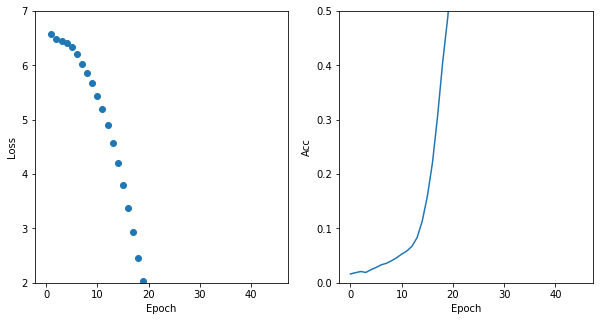

In [16]:
import csv

with open('TrainLog.csv', 'r') as f:
    Data = np.array(list(csv.reader(f, delimiter=',')))
    
Data = np.array(Data[1:,:],dtype=np.float)
    
epoch, acc, loss = Data[:,0],Data[:,1], Data[:,2]

pyplot.figure(figsize=(10,5))
pyplot.subplot(1,2,1)
pyplot.scatter(epoch,loss)
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.ylim([2,7])
pyplot.subplot(1,2,2)
pyplot.plot(epoch,acc)
pyplot.ylabel('Acc')
pyplot.xlabel('Epoch')
pyplot.ylim([0,.5])
pyplot.show()

In [17]:
def MakeInputType(PHRASE,train_length):
    seedbase = np.zeros(train_length,dtype=float)
    seedbase = np.reshape(seedbase, (1, train_length))
    
    seed = [Char_to_Int[char] for char in PHRASE] 
    seed = np.array(seed) 

    seedbase[0,-len(seed):] = seed[:]
    return seedbase
    

In [20]:
# pick a random seed
train_length = 10

random = np.random.randint(10,size=train_length)+1

R = ''
for i in range(len(random)):
    R += str(Int_to_Char[random[i]])+' '

Phrase = 'when i look upon your face'
Phrase = keras.preprocessing.text.text_to_word_sequence(Phrase)
LenOG =len(Phrase)


seed = MakeInputType(Phrase[-train_length:],train_length)
print(seed)

[[ 27.   6. 114.  91.  31. 127.]]


In [21]:
X = seed

for i in range(1000):
    prediction = np.argmax(model.predict(X, verbose=0))
    Phrase.append(Int_to_Char[prediction])
    X = MakeInputType(Phrase[-train_length:],train_length)
    
Generated = ''
GeneratedOG = ''
for i in range(len(Phrase)):
    Generated += Phrase[i]+' '
    if i < LenOG:
        GeneratedOG += Phrase[i]+' '
print(GeneratedOG)
print(Generated)

when i look upon your face 
when i look upon your face to back their swift dispatch too ride o'er stand on thy view sweet play'st taken thy view time's still must none be shown write be any true true unear'd womb in you despise come raz'd heaven's tell be change slow well hell in worst head doting sight to dote his blood increase fears the leaves force men worms rain we do come hence slow by happy show keep me read my true new single grief taken you have rang'd so vile in my brain doth move give trust it do call my love doth 'scap'd my tongue part out may lay give me bring my slave ' then call me read such me doth you be near hour back to be one friend desire forth whit your will one sorrow hate' to despise me read come see me well well love it love my love excuse live what is it in your desire whose mine eyes you despise what is is he do see it so do be near tomb age to thy fair part fall of words part are time come appear to our purpose friend pictur'd a fee is one show no in which w